In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
from functools import partial

START_DATE = '2017-01-01'
END_DATE = '2019-01-01'

In [59]:
def make_frame(content):
    prices = {}
    for line in content.split('\n'):
        if '{' in line or '}' in line:
            continue
        data = (
            line
            .lstrip().lstrip("'")
            .rstrip().rstrip("',")
            .split(':')
        )
        if len(data) < 3:
            data.append(np.nan)
        secs, price, volume = data
        prices[int(secs)] = (int(price), float(volume))
        
    price_frame = pd.DataFrame(prices, index = ['price', 'volume']).T
    price_frame.index = pd.to_datetime(price_frame.index, unit = 's')
    
    return price_frame

def fetch_from_wiki(item_name):
    # Totally lifted from:
    # https://github.com/osrsbox/osrsbox.github.io/blob/master/_posts/2018-12-14-scraping-the-osrs-wiki-part3.md
    
    # Construction custom user-agent for query
    custom_agent = {
        'User-Agent': 'CSCE421Scraper',
        'From': 'presley.graham@tamu.edu' 
    }
    
    page_title = f'Module:Exchange/{item_name}/Data'

    # Construct the para.meters of the API query
    parameters = {
        'action': 'parse',
        'prop': 'wikitext',
        'format': 'json',
        'page': page_title,
    }

    # Call the API using the custom user-agent and parameters
    result = requests.get('https://oldschool.runescape.wiki/api.php', 
                            headers=custom_agent, 
                            params=parameters).json()
    
    content = result['parse']['wikitext']['*']
    return make_frame(content)

In [60]:
def item_filename(item_name):
    return os.path.join('data', f'{item_name}.csv')

def fetch_from_disk(item_name):
    file_name = item_filename(item_name)
    
    # First, check to make sure the item is actually on disk
    if not os.path.isfile(file_name):
        return None
    
    # Read in the price frame; manually set index to first line
    price_frame = pd.read_csv(file_name).set_index('Unnamed: 0')
    
    display(price_frame)
    
    # Get rid of the ugly index name
    price_frame.index.name = None
    
    return price_frame

In [61]:
from functools import lru_cache

# fetch(item_name) returns 
@lru_cache(maxsize = None)
def fetch(item_name):
    # check if we have the item data on disk
    # TODO: check if the data is too old
    price_frame = None #fetch_from_disk(item_name)
    if price_frame is not None:
        return price_frame
    
    # if not, fetch it from the wiki
    price_frame = fetch_from_wiki(item_name)
    # and dump it to a file
    price_frame.to_csv(item_filename(item_name))
    return price_frame

In [266]:
# make mean 0
def demean(series):
    return series - series.mean()

def remove_outliers(series, sigma = 3):
    mean, std_dev = series.mean(), series.std()
    min_value = mean - sigma * std_dev
    max_value = mean + sigma * std_dev
    return series[(min_value <= series) & (series <= max_value)]

# half-open interval, like range()
def limit_to_dates(series, start_on = '1980-01-01', end_before = '2021-01-01'):
    start_date = pd.to_datetime(start_on)
    end_date = pd.to_datetime(end_before)
    return series[(start_date <= series.index) & (series.index < end_date)]

In [267]:
def prices(item_name):
    price = fetch(item_name)['price'].dropna()
    return price

def returns(item_name, lookback = 2):
    price = prices(item_name)
    return ((price - price.shift(lookback)) / price).dropna()

def gold_traded(item_name):
    prices = fetch(item_name)['price'] 
    volumes = fetch(item_name)['volume']
    return (prices * volumes).dropna()

In [268]:
def clean_returns(item_name, lookback = 4):
    raw_returns = returns(item_name, lookback)
    # set to zero mean and remove crazy outliers
    cleaned_returns = remove_outliers(demean(raw_returns), sigma = 4)
    # keep 2019 and beyond pristine
    cleaned_returns = limit_to_dates(cleaned_returns, start_on = START_DATE, end_before = END_DATE)
    return cleaned_returns

def oos_returns(item_name, lookback = 4):
    raw_returns = returns(item_name, lookback)
    # set to zero mean and remove crazy outliers
    cleaned_returns = remove_outliers(demean(raw_returns), sigma = 4)
    # use out of sample only
    cleaned_returns = limit_to_dates(cleaned_returns, start_on = END_DATE)
    return cleaned_returns


def clean_prices(item_name):
    raw_prices = prices(item_name)
    cleaned_prices = limit_to_dates(raw_prices, start_on = START_DATE, end_before = END_DATE)
    return cleaned_prices

def percent_prices(item_name):
    price = clean_prices(item_name)
    return price / price.mean()

In [269]:
def to_2d_array(df):
    if type(df) is pd.Series:
        return df.values.reshape(-1, 1)
    elif type(df) is pd.DataFrame:
        return df.values
    else:
        return df

def common_index(*series):
    common_index = series[0].index
    for serie in series[1:]:
        common_index &= serie.index
    return common_index

In [270]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, f1_score
from sklearn.svm import SVC # "Support vector classifier"

def get_svc_data(pred_names, resp_name, hold_period = 2, threshold = 0.03):
    if type(pred_names) is not list:
        pred_names = [pred_names]
    if resp_name not in pred_names:
        pred_names.append(resp_name)
    
    resp = (clean_returns(resp_name, lookback = hold_period).shift(-hold_period) > threshold).rename(resp_name)
    pred_list = [clean_returns(pred_name).rename(pred_name) for pred_name in pred_names]

    index = common_index(resp, *pred_list)
    
    pred = pd.concat(pred_list, axis = 1).reindex(index)
    resp = resp.reindex(index)
    
    X = to_2d_array(pred)
    y = to_2d_array(resp).reshape(-1)
    
    return X, y

def train_svc_model(pred_names, resp_name, threshold = 0.01):
    X, y = get_svc_data(pred_names, resp_name)
    
    model = SVC()
    model.fit(X, y)
    
    return model
    
def plot_svc_model(model, pred_names, resp_name, ax = None, plot_support = True):
    # source: https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
    
    X, y = get_svc_data(pred_names, resp_name)

    if ax is None:
        ax = plt.gca()
        
    xlim = (min(X[:, 0]) - 0.05, max(X[:, 0]) + 0.05)
    ylim = (min(X[:, 1]) - 0.05, max(X[:, 1]) + 0.05)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');

def evaluate_svc_model(model, pred_names, resp_name):
    X, y_true = get_svc_data(pred_names, resp_name)
    y_pred = model.predict(X)
    
    return f1_score(y_true, y_pred)
    
def beta(pred_names, resp_name, ax = None, func = clean_returns):
    if type(pred_names) is not list:
        pred_names = [pred_names]
    
    resp = func(resp_name).rename(resp_name)
    pred_list = [func(pred_name).rename(pred_name) for pred_name in pred_names]

    index = common_index(resp, *pred_list)
    
    pred = pd.concat(pred_list, axis = 1).reindex(index)
    resp = resp.reindex(index)
    
    X = to_2d_array(pred)
    y = to_2d_array(resp)
    
    model = LinearRegression(fit_intercept = True)
    model.fit(X, y)
    
    if ax is not None:
        assert len(pred_names) == 1, "can only make 2D plots with 1 predictor and 1 response"
        sns.regplot(pred, resp, ax = ax)
    
    betas = list(model.coef_[0])
    r2 = r2_score(y_true = y, y_pred = model.predict(X))
    if len(betas) == 1:
        betas = betas[0]
    return betas, r2


def plot_over_time(*item_names, func = clean_prices):
    frame = pd.concat([func(item_name).rename(item_name) for item_name in item_names], axis = 1)
    frame.plot()

In [287]:
def amount_to_trade(pred_name, resp_name, lookback, threshold, wrong_way = False, func = clean_returns):
    beta_, _ = beta(pred_name, resp_name, func = partial(clean_returns, lookback = lookback))
    
    actual_returns = func(resp_name, lookback = lookback)
    predicted_returns = beta_ * func(pred_name, lookback = lookback)
    
    index = common_index(actual_returns, predicted_returns)
    actual_returns = actual_returns.reindex(index)
    predicted_returns = predicted_returns.reindex(index)
    
    remaining_trade = (predicted_returns - actual_returns).reindex(index)
    
    remaining_trade[remaining_trade.abs() < threshold] = 0
    if not wrong_way:
        remaining_trade[(remaining_trade > 0) != (predicted_returns > 0)] = 0
    
    return remaining_trade

def score(item_name, trades, hold_time, func = clean_returns):
    true_profit = func(item_name, lookback = hold_time).shift(-hold_time)
    
    return trades * true_profit

def quick_eval(pred_name, resp_name, switch, total_time, threshold, func = clean_returns):
    trades = amount_to_trade(pred_name, resp_name, lookback = switch, threshold = threshold, func = func)
    scores = score(resp_name, trades, total_time - switch, func = func)
    display(scores[scores.abs() > 0])
    return scores.sum()

def test_eval(pred_name, resp_name, switch, total_time, threshold):
    return quick_eval(pred_name, resp_name, switch, total_time, threshold, oos_returns)

(0.9906905203633053, 0.9048434979695132)

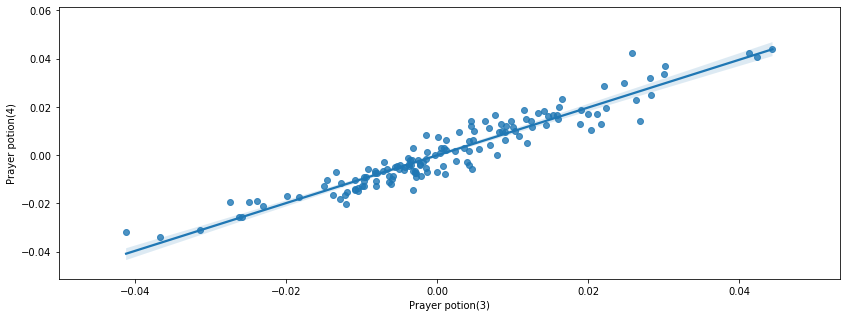

In [282]:
func_to_plot = lambda item_name : limit_to_dates(returns(item_name), '2018-08-01', '2019-01-01')
beta('Prayer potion(3)', 'Prayer potion(4)', func = func_to_plot, ax = plt.axes())

SHORT: beta: 0.338, r^2: 0.149
LONG:  beta: 0.551, r^2: 0.376


2017-01-09    0.000670
2017-01-20    0.000385
2017-01-21    0.001434
2017-01-22    0.002838
2017-02-01    0.000305
                ...   
2018-12-10    0.000276
2018-12-16    0.001103
2018-12-17    0.002874
2018-12-24   -0.002038
2018-12-25   -0.001807
Name: price, Length: 270, dtype: float64

in training: 0.01706874054286282


2019-01-04   -0.000466
2019-01-05    0.000385
2019-01-06    0.001746
2019-01-07    0.001330
2019-01-11   -0.002556
                ...   
2020-04-15    0.001244
2020-04-16   -0.001599
2020-04-17   -0.001891
2020-04-18   -0.001137
2020-04-26    0.000181
Name: price, Length: 255, dtype: float64

in testing:  0.1187978069194989
1.5166680869813918


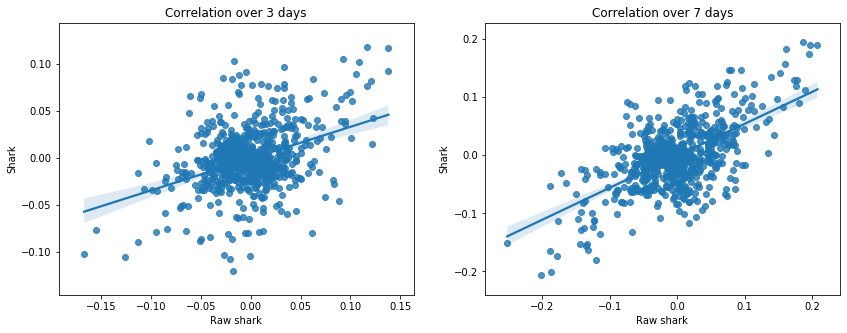

In [314]:
PRED = "Raw shark"
RESP = "Shark"
SHORT = 3
LONG = 7
THRESHOLD = 0.01

plt.rcParams["figure.figsize"] = (14, 5)

short_ax = plt.subplot(121) if type(PRED) is not list else None
long_ax = plt.subplot(122) if type(PRED) is not list else None

b, r = beta(PRED, RESP, func = partial(clean_returns, lookback = SHORT), ax = short_ax)
print(f"SHORT: beta: {b :.3f}, r^2: {r :.3f}")

b, r = beta(PRED, RESP, func = partial(clean_returns, lookback = LONG), ax = long_ax)
print(f"LONG:  beta: {b :.3f}, r^2: {r :.3f}")

if short_ax is not None:
    short_ax.set_title(f'Correlation over {SHORT} days')
    long_ax.set_title(f'Correlation over {LONG} days')

print('in training:', quick_eval(PRED, RESP, SHORT, LONG, THRESHOLD))
print('in testing: ', test_eval(PRED, RESP, SHORT, LONG, THRESHOLD))

print((1 + oos_returns('Raw shark')).prod())

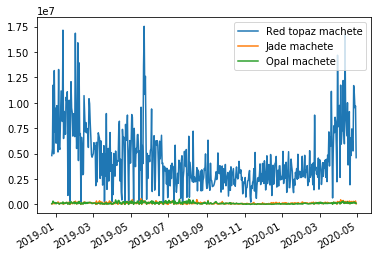

In [85]:
plot_over_time("Red topaz machete", "Jade machete", "Opal machete", func = gold_traded)

In [ ]:
model = train_svc_model("Ranarr weed", "Prayer potion(4)")

In [12]:
plot_svc_model(model, "Ranarr weed", "Prayer potion(4)")

NameError: name 'model' is not defined

In [215]:
evaluate_svc_model(model, "Ranarr weed", "Prayer potion(4)")

array([False, False, False, False, False, False, False,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False,  True, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False,  True,  True,  True, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

0.0

(0.5302085192914114, 0.5014682688190052)

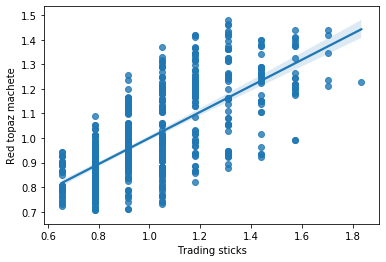

In [92]:
beta("Trading sticks", "Red topaz machete", func = partial(percent_prices), plot = True)

(0.0015537019238693209, 0.00012541373711172366)

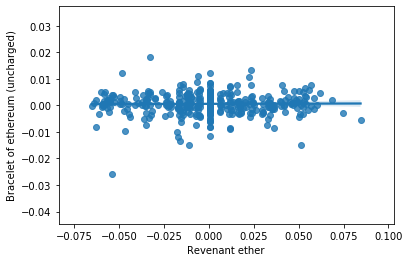

In [96]:
beta("Revenant ether", "Bracelet of ethereum (uncharged)", func = partial(clean_returns, lookback = 1), plot = True)